<a href="https://colab.research.google.com/github/0szgn0/Bitcoin-Anomaly-Detection/blob/main/The_Clean_Data_And_The_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("ellipticco/elliptic-data-set")

df_classes = pd.read_csv(f"{path}/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_features = pd.read_csv(f"{path}/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

# editing the col names of the futures
# the first col 'txId' (transaction ID), other features (V1, V2... V166)
col_names = ['txId', 'time_step'] + [f'V{i}' for i in range(1, 166)]
df_features.columns = col_names

# merging 2 files
df = pd.merge(df_features, df_classes, on='txId', how='left')
print(df.head())

print("Data Distribution:")
print(df['class'].value_counts())

# clearing the data for supervised learning
# 1: Illicit, 2: Licit. Editing these according to 1 (Fraud) and 0 (Normal).
data = df[df['class'] != 'unknown'].copy()
data['class'] = data['class'].map({'1': 1, '2': 0})

print("\nData Dist ready for the training:")
print(data['class'].value_counts())

X = data.drop(['txId', 'class'], axis=1) # txId tahmin için gereksiz
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

100%|██████████| 146M/146M [00:00<00:00, 154MB/s]

Extracting files...


        txId  time_step        V1        V2        V3         V4        V5  \
0    5530458          1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
1  232022460          1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
2  232438397          1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
3  230460314          1  1.011523 -0.081127 -1.201369   1.153668  0.333276   
4  230459870          1  0.961040 -0.081127 -1.201369   1.303743  0.333276   

         V6         V7        V8  ...      V157      V158      V159      V160  \
0 -0.113002  -0.061584 -0.162112  ...  0.673103 -0.979074 -0.978556  0.018279   
1 -0.113002  -0.061584 -0.162749  ...  0.439728 -0.979074 -0.978556 -0.098889   
2  9.782742  12.414558 -0.163645  ... -0.613614  0.241128  0.241406  1.072793   
3  1.312656  -0.061584 -0.163523  ... -0.400422  0.517257  0.579382  0.018279   
4  1.480381  -0.061584 -0.163577  ... -0.422589 -0.226790 -0.117629  0.018279   

       V161      V162      V163      V164   

Predicting on test set...

--- Final Classification Report ---
              precision    recall  f1-score   support

   Licit (0)       0.99      1.00      0.99     10505
 Illicit (1)       0.98      0.90      0.94      1136

    accuracy                           0.99     11641
   macro avg       0.99      0.95      0.97     11641
weighted avg       0.99      0.99      0.99     11641


--- Confusion Matrix ---


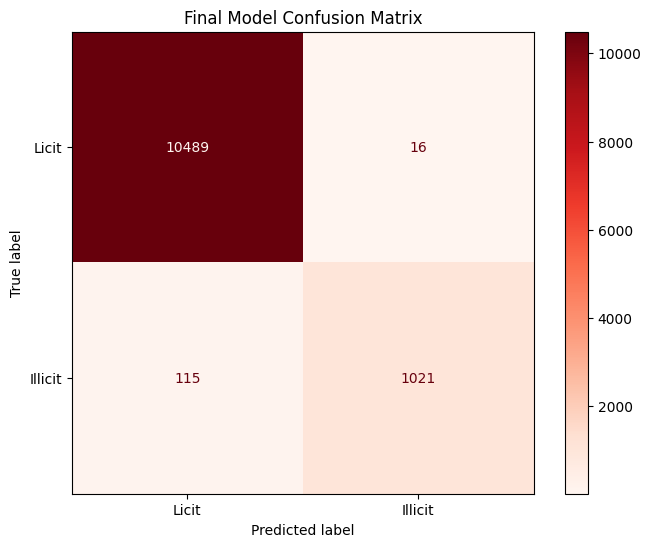

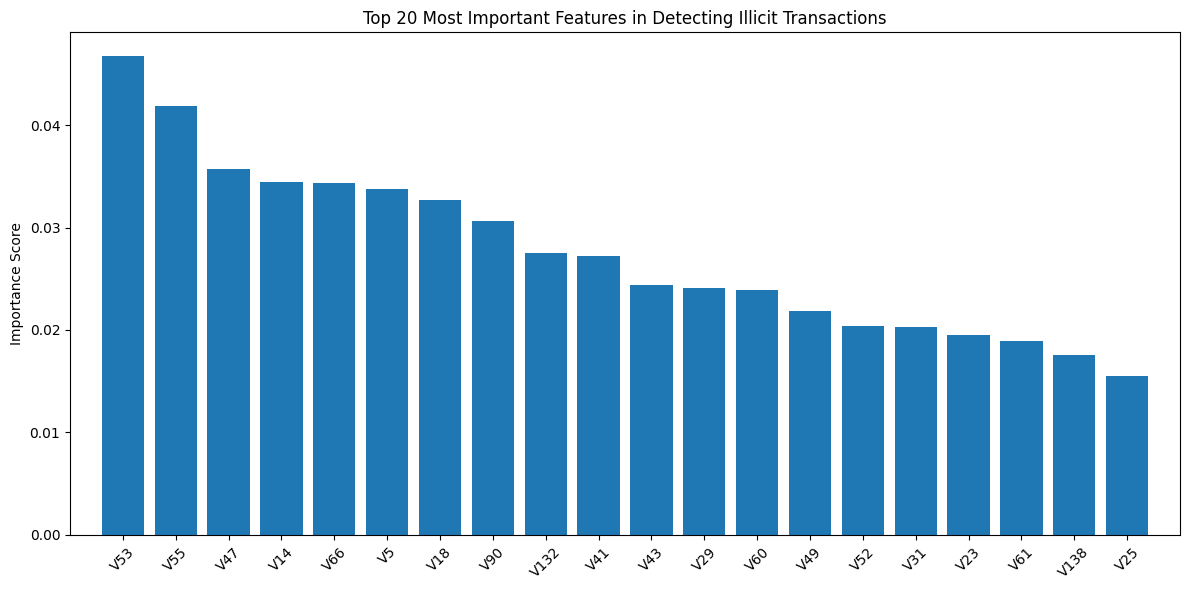

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=False,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Predicting on test set")
y_pred = rf_model.predict(X_test)

print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Licit (0)', 'Illicit (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Reds', ax=ax, values_format='d')
plt.title('Final Model Confusion Matrix')
plt.show()

# Feature Importance Visualization
# This shows which anonymous features were most important for detection
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20] # Top 20 features

plt.figure(figsize=(12, 6))
plt.title("Top 20 Most Important Features in Detecting Illicit Transactions")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X_train.columns[i] for i in indices], rotation=45)
plt.xlim([-1, len(indices)])
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()